# Test **CRAFT** Pytorch on Object dataset

In this notebook, we use CRAFT to extract concepts of **Objects dataset** with **ResNet50** and then display them using Concept Attribution Maps 

# 1 - Loading and preparing the model

🛠 CRAFT requires splitting the model in two parts. So, we will prepare two functions $(g, h)$ such that $f(x) = (g \cdot h)(x)$. To put it simply, $g$ is the function that maps our input to the latent space (the penultimate layer of our model), and $h$ is the function that maps this penultimate layer to the output. It is important to note that if the model contains a global average pooling layer, it is strongly recommended to provide CRAFT with the layer before the global average pooling.

⚠️ Please keep in mind that the activations must be positives (after relu or any positive activation function)

In [1]:
#!pip install -q timm
#!pip install Craft-xai


In [7]:
import numpy as np
import cv2
import torch
import torch.nn as nn

from torchvision import transforms
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from pathlib import Path
from PIL import Image

device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

# loading any timm model
model = timm.create_model('nf_resnet50.ra2_in1k', pretrained=True)
model = model.eval().to(device)

# processing
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
to_pil = transforms.ToPILImage()

# cut the model in two
g = nn.Sequential(*(list(model.children())[:4])) # input to penultimate layer
h = lambda x: model.head.fc(torch.mean(x, (2, 3))) # penultimate layer to logits

# 1- loading some images of Object !

In [1]:
# Download latest version
import kagglehub
import os
path = kagglehub.dataset_download("mohamedmaher5/vehicle-classification")

print("Path to dataset files:", path)
relative_path = os.path.relpath(path)
print("Path to dataset files:", relative_path)

100%|██████████| 827M/827M [00:21<00:00, 40.6MB/s] 

Extracting files...


Path to dataset files: /Users/phuongnguyen/.cache/kagglehub/datasets/mohamedmaher5/vehicle-classification/versions/1
Path to dataset files: ../../../../.cache/kagglehub/datasets/mohamedmaher5/vehicle-classification/versions/1


In [ ]:

list_paths = list(Path(relative_path, 'Vehicles/Cars').rglob('*.jpg'))
print(len(list_paths))
# load the image and convert into
# numpy array
all_arrays = []
images_tf = []
for path in list_paths[:100]:
    img = Image.open(path)

    # asarray() class is used to convert
    # PIL images into NumPy arrays
    numpydata = np.asarray(img)
    image_tf = transform(to_pil(numpydata.astype(np.uint8)))
    images_tf.append(image_tf)
    #print(numpydata)
    #np.savez(f"/home/ids/nnguyen-24/.cache/kagglehub/datasets/dataclusterlabs/table-image-dataset-indoor-object-detection/versions/{path.stem}.npz",numpydata)


789
(193, 261, 3)
(108, 162, 3)
(183, 275, 3)
(140, 111, 3)
(140, 114, 3)
(183, 275, 3)
(165, 299, 3)
(275, 183, 3)
(108, 162, 3)
(224, 225, 3)
(140, 140, 3)
(91, 162, 3)
(118, 162, 3)
(183, 275, 3)
(183, 275, 3)
(100, 100, 3)
(183, 275, 3)
(91, 162, 3)
(183, 276, 3)
(168, 300, 3)
(183, 275, 3)
(100, 100, 3)
(78, 162, 3)
(100, 100, 3)
(108, 162, 3)
(183, 275, 3)
(183, 275, 3)
(183, 275, 3)
(275, 183, 3)
(118, 162, 3)
(183, 275, 3)
(168, 300, 3)
(122, 162, 3)
(225, 225, 3)
(137, 367, 3)
(190, 265, 3)
(259, 194, 3)
(108, 162, 3)
(190, 265, 3)
(168, 300, 3)
(121, 280, 3)
(225, 225, 3)
(179, 281, 3)
(168, 300, 3)
(213, 237, 3)
(168, 300, 3)
(85, 162, 3)
(420, 630, 3)
(100, 100, 3)
(108, 162, 3)
(183, 275, 3)
(178, 284, 3)
(183, 275, 3)
(162, 311, 3)
(91, 162, 3)
(168, 299, 3)
(101, 162, 3)
(100, 100, 3)
(91, 162, 3)
(194, 259, 3)
(251, 201, 3)
(103, 162, 3)
(100, 100, 3)
(168, 299, 3)
(176, 286, 3)
(108, 162, 3)
(100, 100, 3)
(86, 162, 3)
(108, 162, 3)
(108, 162, 3)
(77, 162, 3)
(120, 162,

In [19]:
images_processed = torch.stack(images_tf, 0)

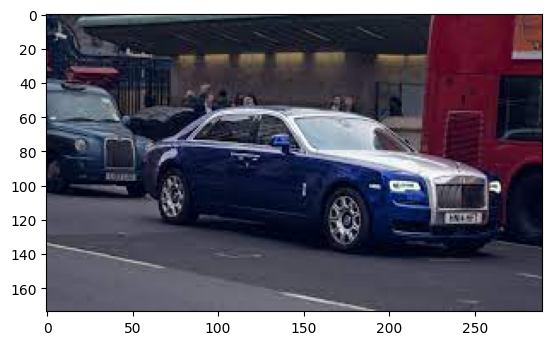

In [22]:
img_class = 824	# dining table, board

import matplotlib.pyplot as plt
# show a example of rabbits dataset
imgplot = numpydata.astype(np.uint8)
plt.imshow(imgplot)


In [23]:
images_processed.shape

torch.Size([100, 3, 256, 256])

# 2- How to use CRAFT


The API of CRAFT is really simple. We have 2 hyperparameters to define. First, the number of concepts ($r$ in the original paper), 10 is enough when we study the penultimate layer for a class of ImageNet. We provide tips and metrics to choose this hyperparameter below.

The second hyperparameter is the `patch_size`, or the size of the patches used for the concept extraction. For image of $224$, we encourage you to stay between $64$ and $128$ (half of the image).

Let's start by instantiating CRAFT



In [24]:
from craft.craft_torch import Craft, torch_to_numpy

craft = Craft(input_to_latent = g,
              latent_to_logit = h,
              number_of_concepts = 10,
              patch_size = 64,
              batch_size = 64,
              device = device)

# now we can start fit the concept using our rabbit images
# CRAFT will (1) create the patches, (2) find the concept
# and (3) return the crops (crops), the embedding of the crops (crops_u), and the concept bank (w)
crops, crops_u, w = craft.fit(images_processed[:100])
crops = np.moveaxis(torch_to_numpy(crops), 1, -1)

crops.shape, crops_u.shape, w.shape

2025-06-15 15:22:51.242300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749993771.475063  562388 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749993771.778487  562388 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749993772.254883  562388 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749993772.255012  562388 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749993772.255032  562388 computation_placer.cc:177] computation placer alr

((1600, 64, 64, 3), (1600, 10), (10, 2048))

# 3- Estimating the concept importance

The second crucial step before starting our investigation is to understand which concepts matter. To do so, we use Sobol indices and we compute them using a really simple api!

In [25]:
importances = craft.estimate_importance(images_processed[:100], class_id=img_class) # 330 is the rabbit class id in imagenet
images_u = craft.transform(images_processed[:100])

images_u.shape

/home/ids/nnguyen-24/Craft/craft/craft_torch.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])
/home/ids/nnguyen-24/Craft/craft/craft_torch.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


(100, 8, 8, 10)

# 4 - Results !

Concept 3  has an importance value of  0.12374492
Concept 9  has an importance value of  0.120517276
Concept 1  has an importance value of  0.06863534
Concept 2  has an importance value of  0.043073725
Concept 5  has an importance value of  0.035080325


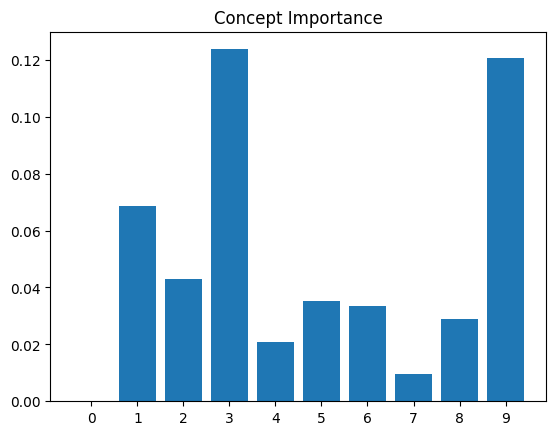

In [27]:
# We are done, let's inspect the results !
# first, lets see which concepts matter
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)))
plt.title("Concept Importance")


most_important_concepts = np.argsort(importances)[::-1][:5]

for c_id in most_important_concepts:
  print("Concept", c_id, " has an importance value of ", importances[c_id])

Concept 3  has an importance value of  0.12374492


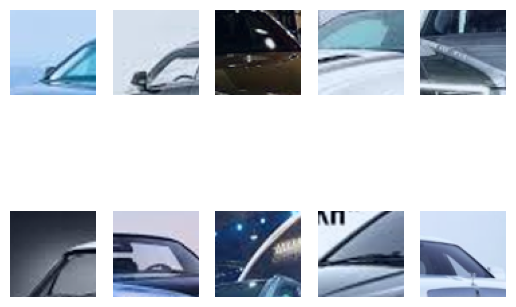

Concept 9  has an importance value of  0.120517276


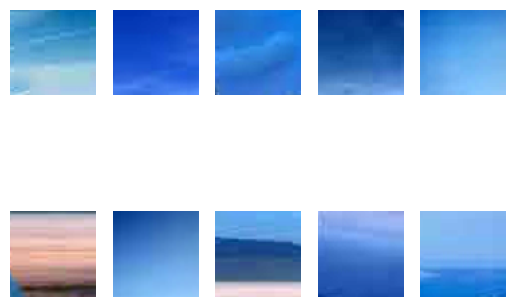

Concept 1  has an importance value of  0.06863534


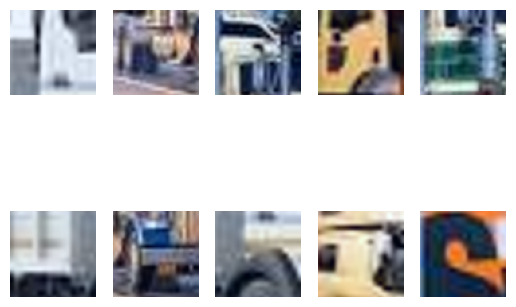

Concept 2  has an importance value of  0.043073725


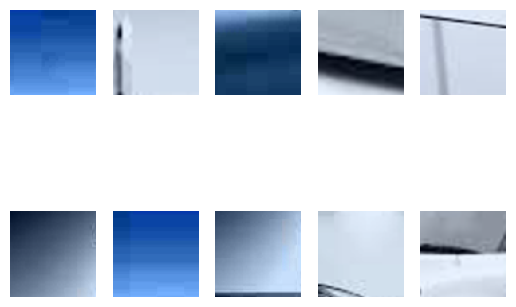

Concept 5  has an importance value of  0.035080325


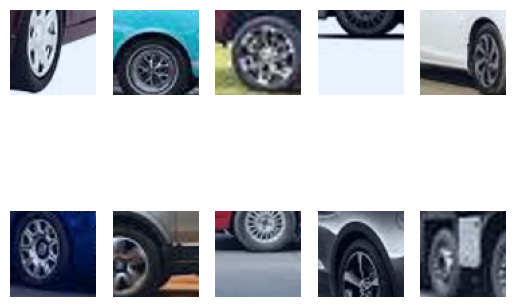

In [ ]:
# Ok nice, let inspect those concepts by showing the 10 best crops for
# each concepts
from math import ceil
nb_crops = 10

def show(img, **kwargs):
  img = np.array(img)
  if img.shape[0] == 3:
    img = img.transpose(1, 2, 0)

  img -= img.min();img /= img.max()
  plt.imshow(img, **kwargs); plt.axis('off')


for c_id in most_important_concepts:

  best_crops_ids = np.argsort(crops_u[:, c_id])[::-1][:nb_crops]
  best_crops = crops[best_crops_ids]

  print("Concept", c_id, " has an importance value of ", importances[c_id])
  for i in range(nb_crops):
    plt.subplot(ceil(nb_crops/5), 5, i+1)
    show(best_crops[i])

  plt.savefig(f'car_concept_{c_id}.png', bbox_inches='tight', dpi=300)
  plt.show()

In [29]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

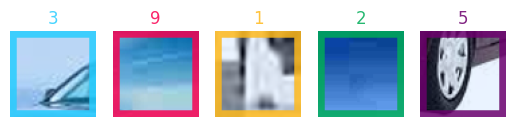

In [30]:
cmaps = [
  get_alpha_cmap((54, 197, 240)),
  get_alpha_cmap((210, 40, 95)),
  get_alpha_cmap((236, 178, 46)),
  get_alpha_cmap((15, 157, 88)),
  get_alpha_cmap((84, 25, 85))
]

def plot_legend():
  for i, c_id in enumerate(most_important_concepts):
    cmap = cmaps[i]
    plt.subplot(1, len(most_important_concepts), i+1)

    best_crops_id = np.argsort(crops_u[:, c_id])[::-1][0]
    best_crop = crops[best_crops_id]

    p = 5
    mask = np.zeros(best_crop.shape[:-1])
    mask[:p, :] = 1.0
    mask[:, :p] = 1.0
    mask[-p:, :] = 1.0
    mask[:, -p:] = 1.0

    show(best_crop)
    show(mask, cmap=cmap)
    plt.title(f"{c_id}", color=cmap(1.0))

  plt.show()

plot_legend()

In [ ]:

def concept_attribution_maps(id, percentile=90, savepath=None):
  img = images_processed[id]
  u = images_u[id]

  show(img)

  for i, c_id in enumerate(most_important_concepts):

    cmap = cmaps[i]
    heatmap = u[:, :, c_id]

    # only show concept if excess N-th percentile
    sigma = np.percentile(images_u[:,:,:,c_id].flatten(), percentile)
    heatmap = heatmap * np.array(heatmap > sigma, np.float32)

    heatmap = cv2.resize(heatmap[:, :, None], (224, 224))
    show(heatmap, cmap=cmap, alpha=0.7)

  if savepath is not None:
    plt.savefig(savepath, bbox_inches='tight', dpi=300)


/tmp/ipykernel_562388/2157479436.py:11: RuntimeWarning: invalid value encountered in divide
  img -= img.min();img /= img.max()


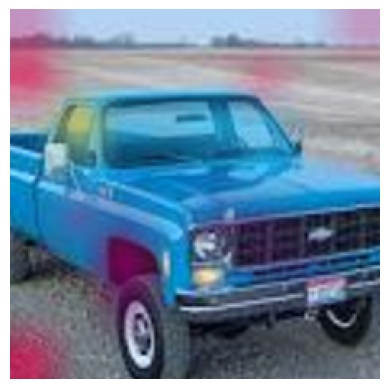

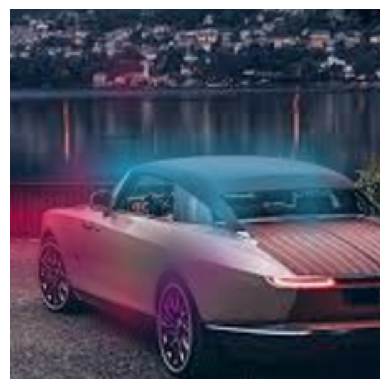

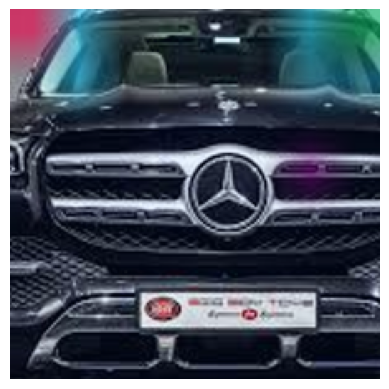

In [48]:
concept_attribution_maps(10, 90, '/home/ids/nnguyen-24/Craft/plots/object_importants_positions.png')
plt.show()

concept_attribution_maps(25)
plt.show()
concept_attribution_maps(2)
plt.show()

/tmp/ipykernel_562388/2157479436.py:11: RuntimeWarning: invalid value encountered in divide
  img -= img.min();img /= img.max()


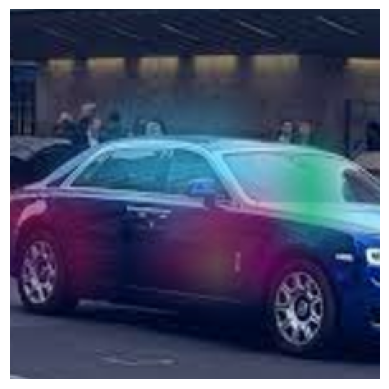

In [49]:
concept_attribution_maps(99, 90, '/home/ids/nnguyen-24/Craft/plots/object_importants_positions.png')
plt.show()